In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

token = './Flickr8k_text/Flickr8k.token.txt'

captions = open(token, 'r').read().strip().split('\n')

d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

images = './Flickr8k_Dataset/Flickr8k_Dataset/'

img = glob.glob(images+'*.jpg')

train_images_file = './Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

train_img = split_data(train_images)

test_images_file = './Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = split_data(test_images)

def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

model = InceptionV3(weights='imagenet')

from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]
        
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')
        
words = [i.split() for i in caps]

# unique = []
# for i in words:
#     unique.extend(i)
    
# unique = list(set(unique))

unique = pickle.load(open('unique.p', 'rb'))

word2idx = {val:index for index, val in enumerate(unique)}

idx2word = {index:val for index, val in enumerate(unique)}

max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)

vocab_size = len(unique)

df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

c = [i for i in df['captions']]

imgs = [i for i in df['image_id']]

Using Theano backend.
Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 960M (0000:02:00.0)


In [2]:
embedding_size = 300

image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py:368: UserWarning: The `regularizers` property of layers/models is deprecated. Regularization losses are now managed via the `losses` layer/model property.
  warnings.warn('The `regularizers` property of '


In [3]:
final_model.load_weights('2017-12-05 18:49:58_loss-0.6350_acc-83.45_adamOptimizer.h5')

In [4]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encode(image)
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [12]:
import random
from scipy.misc import imread

# %matplotlib inline
# r = random.randint(0, len(test_img)-1)

# try_image = test_img[361]
try_image = '/home/pritish/Pictures/Webcam/2017-12-04-175314.jpg'
#print(try_image)

def plot_image(image):
    plt.imshow(imread(image))
    plt.show()
    plt.clf()

def generate_captions(samples):
    for idx in samples:
        img = test_img[idx]
        plot_image(img)
        print("Generated Caption:", predict_captions(img))

## Good Results

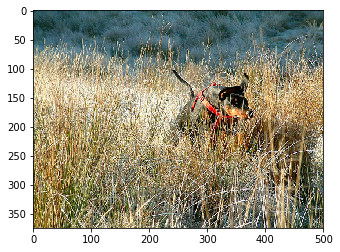

Generated Caption :  A black dog is running through the field of tall grass .


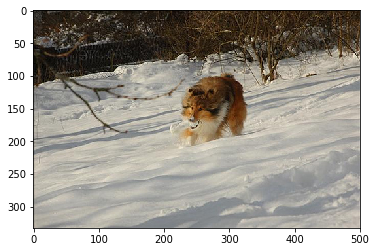

Generated Caption :  A golden dog runs through the snow .


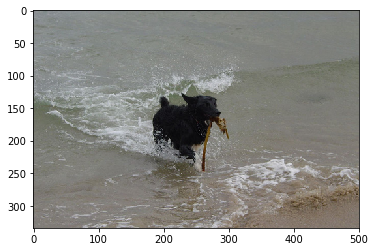

Generated Caption :  A black dog is running through the water .


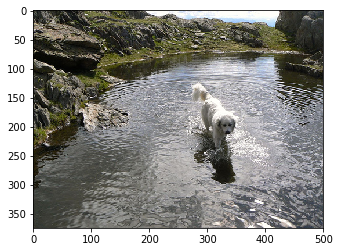

Generated Caption :  A white dog walks through the water .


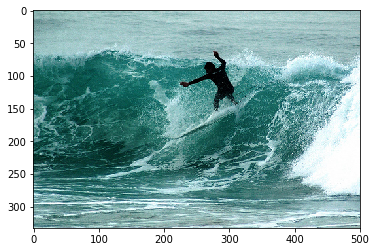

Generated Caption :  A man is surfing a large wave in the ocean .


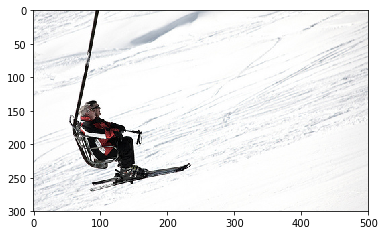

Generated Caption :  A man is skiing in the white snow .


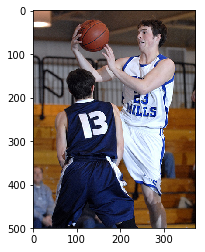

Generated Caption :  Two basketball players fighting over the ball .


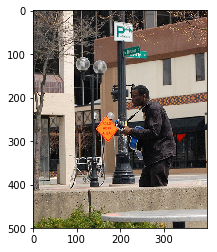

Generated Caption :  A man is standing on a stone wall and carrying a small sign


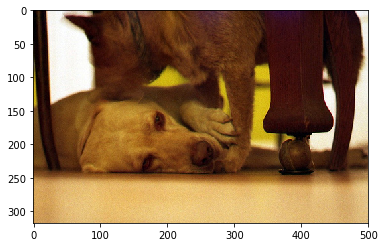

Generated Caption :  A large brown dog is standing next to a young brown dog while it is laying on the ground .


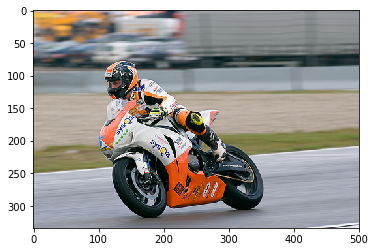

Generated Caption :  A motorcyclist is about to fall over .


In [246]:
good_results=[340,257,642,996,787,35,846,570,277,482]
generate_captions(good_results)

## Bad Results

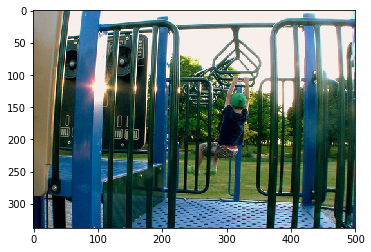

Generated Caption :  A dog is looking at a black dog that is white on the ground .


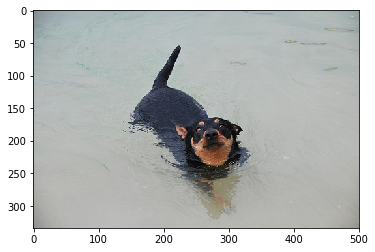

Generated Caption :  Two black , brown and black dogs are swimming in the water .


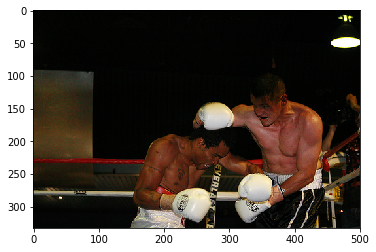

Generated Caption :  A man in a white shirt and a man in a black shirt and white shorts playing a boy with a gold baseball cap down .


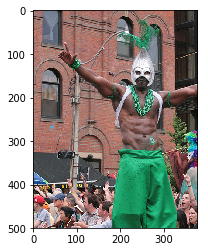

Generated Caption :  A woman wearing a pink sweatshirt holds a basketball and another fluffy girl .


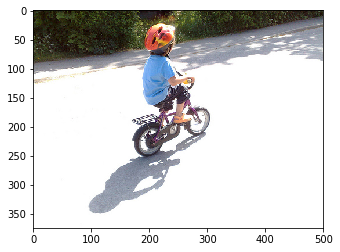

Generated Caption :  A boy on a bicycle rides the ledge of water fountain while another boy is in the air .


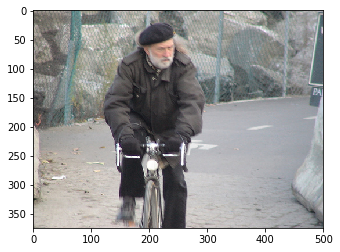

Generated Caption :  A man rides a skateboard up the side of a rocky trail as a group of people walk behind him .


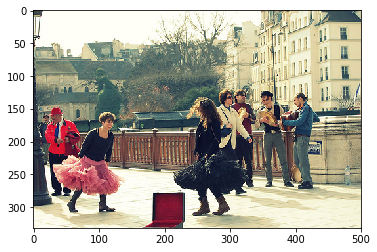

Generated Caption :  A group of people are flying ski while another dog holds another while a dog looks the ground .


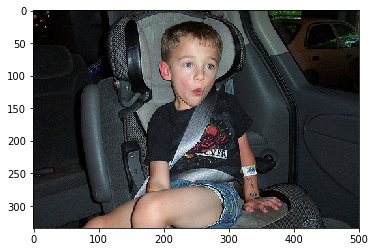

Generated Caption :  A woman wearing a scarf and striped outfit is sitting in the middle of a window that is go covered in a car .


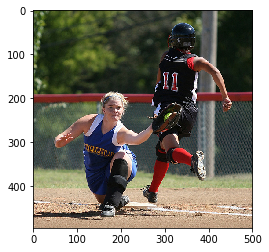

Generated Caption :  A boy wearing a blue sports uniform kicks a soccer ball in a baseball game .


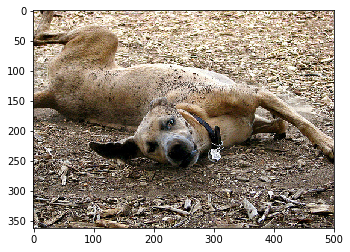

Generated Caption :  A tan dog is playing with a white dog in a tube .


In [247]:
bad_results=[180,432,209,102,590,839,571,746,452,312]
generate_captions(bad_results)

## Testing

In [15]:
results = []

for i in test_img:
    results.append(predict_captions(i))

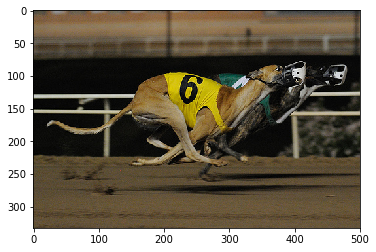

[['A', 'brown', 'number', 'six', 'race', 'dog', 'is', 'slightly', 'behind', 'a', 'black', 'race', 'dog', 'on', 'a', 'track', '.'], ['two', 'dogs', 'race', 'across', 'the', 'track', '.'], ['Two', 'greyhounds', 'race', '.'], ['two', 'muzzled', 'greyhound', 'dogs', 'running', 'around', 'a', 'track'], ['Two', 'muzzled', 'racing', 'dogs', 'running', 'along', 'track', '.']]
['A', 'dog', 'wearing', 'a', 'white', 'and', 'black', 'shirt', 'is', 'on', 'a', 'track', '.']


In [87]:
labels = []
for i in test_img:
    temp = []
    for j in test_d[i]:
        temp.append(j.split())
    
    labels.append(temp)

split_results = []
for i in results:
    split_results.append(i.split())
    
r = random.randint(0, len(test_img) - 1)
plot_image(test_img[r])
print (labels[r])
print (split_results[r])

In [96]:
from nltk.translate.bleu_score import corpus_bleu
references = labels
candidates = split_results
score = corpus_bleu(references, candidates)
print("BLEU corpus score:", score)

BLEU corpus score: 0.11483006328010045


In [97]:
from nltk.translate.bleu_score import sentence_bleu

score = []
for r in range(len(test_img)):
    reference = labels[r]
    candidate = split_results[r]
    score.append(sentence_bleu(reference, candidate))
print("BLEU average score:", np.mean(score))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU average score: 0.487279552899


In [98]:
import spacy
import wmd

nlp = spacy.load('en', create_pipeline=wmd.WMD.create_spacy_pipeline)

scores = []
for i, j in enumerate(test_img):
    res = nlp(results[i])
    for k in test_d[j]:
        temp = nlp(k)
        scores.append(temp.similarity(res))

print ("WMD:", np.mean(scores))

WMD: 0.778158775496
